Demonstrate making and applying calibration of phase and amplitude for a scan.

In general, the "calbration" data are calculated with a direct loop-back and then are applied to data collected while connected to actual resonators.  In these examples, we retain the loop back connection for both the calibration and the data.  This should result in "flat" scans in amplitude and phase.

In [1]:
import importlib
from mkids import TopSoc
import numpy as np
import matplotlib.pyplot as plt
import Scan
import pickle
soc = TopSoc()

In [2]:
fNyIn = soc.fsIn/2
print("fNyIn =",fNyIn)

fNyIn = 1228.8


In [25]:
# Define the area to calibrate, based on an (arbitrary) mixer setting
fMixer = 0.75*soc.fsIn
fMixer = 3800 # this gets us to the loud frequency range

print("fMixer =",fMixer)
soc.set_mixer(fMixer)
f0 = fMixer + 85.4
f1 = fMixer + 95.6
fTone = 0.5*(f0+f1)
print("fTone =",fTone)

fMixer = 3800
fTone = 3890.5


measure nominal dealy for fTone=3890.500000  outCh=38


  0%|          | 0/20 [00:00<?, ?it/s]

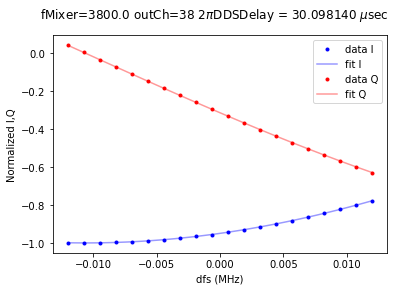

In [26]:
# Measure the nominal delay near fTone
scan = Scan.Scan(soc)
outCh = scan.soc.outFreq2ch(fTone)
print("measure nominal dealy for fTone=%f  outCh=%d"%(fTone, outCh))
nominalDelay = scan.measureNominalDelay(outCh, decimation=2, doProgress=True, doPlot=True)

In [27]:
# Make a calibration with nt transfers at nf frequencies, with the nominalDelay correction applied
nt,nf = 1,201
print("f0 =",f0)
print("f1 =",f1)
calibration = scan.makeCalibration(fMixer, f0, f1, nf=nf, nt=nt, doProgress=True,
                            nominalDelay=nominalDelay)
fscan = calibration['fscan']
print("delayApplied =",fscan['delayApplied'])


f0 = 3885.4
f1 = 3895.6


  0%|          | 0/201 [00:00<?, ?it/s]

delayApplied = 30.09813992908285


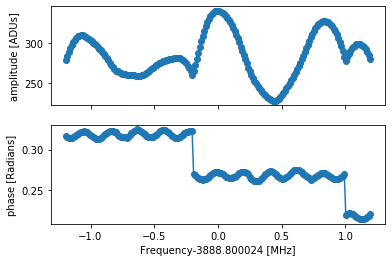

In [28]:
# Take a look at part of the calibration data, for one of the PFB bins
iTone = 2
Scan.fscanPlot(fscan, iTone)


In [29]:
# For convenience, arrange these points as a single spectrum
spectrum = Scan.fscanToSpectrum(fscan)

In [30]:
# These frequencies define where there will be discontinuities in I,Q values
importlib.reload(Scan)
scan = Scan.Scan(soc)
fList = scan.makeFList(fMixer, f0, f1,verbose=True)
print(fList)

input boundaries  freq=3885.00 fEnd=3895.80
[3885.20002441 3886.2        3887.4        3887.60002441 3888.6
 3889.8        3890.00002441 3891.         3892.2        3892.40002441
 3893.4        3894.6        3894.80002441 3895.8       ]


Text(0.5, 0, 'frequency (MHz)')

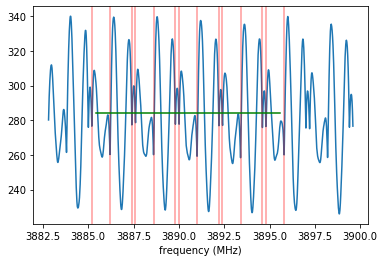

In [31]:
# Plot the amplitudes, along with vertical lines showing where discontinuities are.  The horizontal green line shows the frequency range requested
plt.plot(spectrum[0],spectrum[1])
for f in fList:
    plt.axvline(f,color='r', alpha=0.4)
aMean = spectrum[1].mean()
plt.plot([f0,f1],[aMean,aMean], 'g')
plt.xlabel("frequency (MHz)")

f0 = 3885.4
f1 = 3895.6


Text(0.5, 0, 'frequency (MHz)')

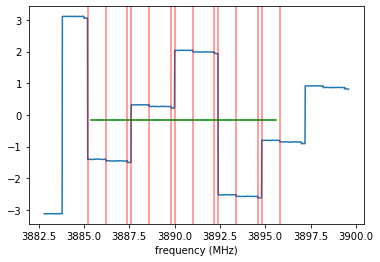

In [32]:
# Plot the phases, along with vertical lines showing where discontinuities are
plt.plot(spectrum[0],spectrum[2])
print("f0 =",f0)
print("f1 =",f1)
for f in fList:
    plt.axvline(f,color='r', alpha=0.5)
pMean = spectrum[2].mean()
plt.plot([f0,f1],[pMean, pMean], 'g')
plt.xlabel("frequency (MHz)")

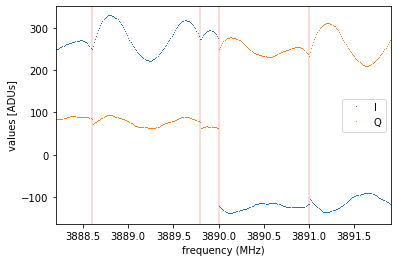

In [33]:
# zoom in a bit and show I, Q values and discontinuities
fMiddle = 0.5*(f0+f1)
fStart = fMiddle-2.3
fEnd = fMiddle+1.4
def iqPlot(fStart, fEnd):
    inds = (spectrum[0] > fStart ) & (spectrum[0] < fEnd)
    sx = spectrum[1]*np.exp(1j*spectrum[2])
    si = np.real(sx)
    sq = np.imag(sx)
    plt.plot(spectrum[0][inds],si[inds], ',', label="I")
    plt.plot(spectrum[0][inds],sq[inds], ',', label="Q")
    for f in fList:
        plt.axvline(f,color='r', alpha=0.2)
    plt.xlim((fStart,fEnd))
    plt.legend()
    plt.xlabel("frequency (MHz)")
    plt.ylabel("values [ADUs]")
iqPlot(fStart, fEnd)

In [34]:
# Pretend we have a few frequencies we want to study.  Define tones of equal amplitude and random phases and scan
nTones = 4
testFreqs = fStart + 2.345*np.arange(nTones)

testAmps = 0.9*np.ones(len(testFreqs))/len(testFreqs)
np.random.seed(1234991)
testFis = np.random.uniform(0, 2*np.pi, size=len(testFreqs))
bandwidth = 0.4 # MHz
nf = 50
decimation = 2
nt = 3
doProgress = True

testFScan = scan.fscan(testFreqs, testAmps, testFis, bandwidth, nf, decimation,nt, doProgress=doProgress)


  0%|          | 0/50 [00:00<?, ?it/s]

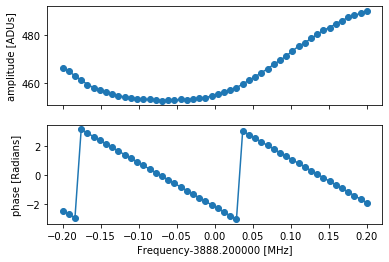

In [35]:
# Plot the measured amplitude,phase of one of the tones
Scan.fscanPlot(testFScan, 0)

In [36]:
# Apply the calibration
tfsCalib = scan.applyCalibration(testFScan, calibration, amplitudeMax=5000)


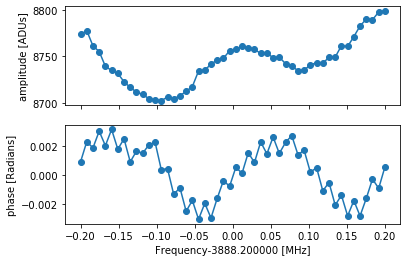

In [37]:
# Plot the calibrated amplitude,phase of one of the tones
Scan.fscanPlot(tfsCalib, 0)

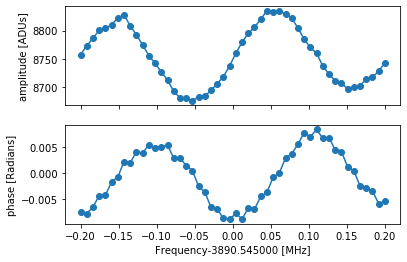

In [38]:
Scan.fscanPlot(tfsCalib, 1)

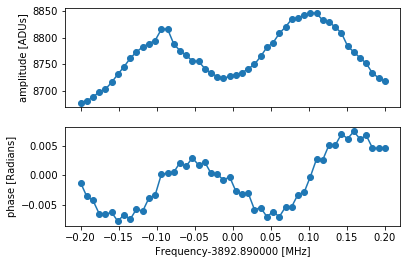

In [39]:
Scan.fscanPlot(tfsCalib, 2)

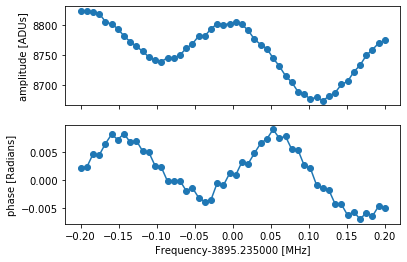

In [40]:
Scan.fscanPlot(tfsCalib, 3)

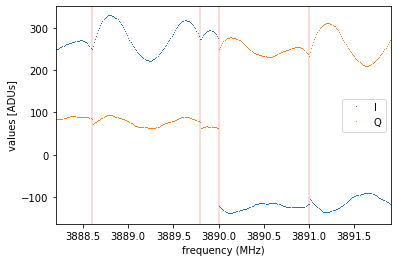

In [41]:
iqPlot(fStart, fEnd)

In [42]:
def apPlot(fStart, fEnd):
    inds = (spectrum[0] > fStart ) & (spectrum[0] < fEnd)
    amp = spectrum[1]
    pha = spectrum[2]
    fig,ax = plt.subplots(2,1,sharex=True)
    
    ax[0].plot(spectrum[0][inds],amp[inds], ',')
    plt.plot(spectrum[0][inds],pha[inds], ',')
    for f in fList:
        ax[0].axvline(f,color='r', alpha=0.2)
        ax[1].axvline(f,color='r', alpha=0.2)
    ax[1].set_xlabel("frequency (MHz)")
    ax[0].set_ylabel("amplitude [ADUs]")
    ax[1].set_ylabel("phase [rad]")
    plt.xlim((fStart,fEnd))


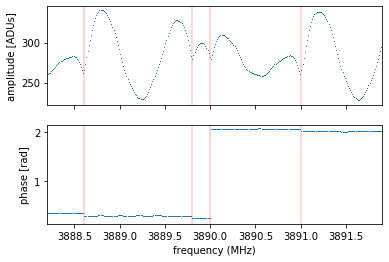

In [43]:
apPlot(fStart, fEnd)